<a href="https://colab.research.google.com/github/MaithriRao/Optimization_/blob/main/sgdResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 
import torch.optim as optim
from torch.utils.data import random_split

#Check device (cuda or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
#transforms 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.247, 0.243, 0.261])
])

#Hyperparameters
batch_size = 128
num_epochs = 100
learning_rate = 0.001
momentum = 0.9


In [6]:
#Load the dataset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

#split trainset into train and validation 
train_ds, val_ds = random_split(trainset, [int(0.8*len(trainset)), int(00.2*len(trainset))])
print(len(train_ds))
print(len(val_ds))
print(len(testset))

#Dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)
validation_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory = True)


#image classes 
num_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
40000
10000
10000


In [7]:
#ResNet Model
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion      
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

#ResNet18 = ResNet(BasicBlock, [2,2,2,2])
ResNet34 = ResNet(BasicBlock, [3,4,6,3]).to(device)
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet34)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [8]:
from torch.optim import optimizer
#loss function 
criterion = nn.CrossEntropyLoss()

#Optimizer
#optimizer = SwatsVanillaGlobal(ResNet34.parameters())
#optimizer = optim.Adam(ResNet34.parameters(), lr= learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(ResNet34.parameters(),lr = learning_rate, momentum = 0.9)

In [9]:
def model_training(model, train_loader, validation_loader, criterion, optimizer, set_device):
  best_accuracy = 0
  train_loss_history = []
  validation_loss_history = []
  training_acc_history = []
  validation_acc_history = []

  for epoch in range(0, num_epochs):
    model.train()
    train_loss_scores = []
    training_acc_scores = []
    correct_predictions = 0

    for batch_index, (images, targets) in enumerate(train_loader):
      images = images.to(set_device)
      targets = targets.to(set_device)
      
      outputs = model(images)
      loss = criterion(outputs, targets)
      train_loss_scores.append(loss.item())
      
      _, preds = torch.max(outputs, 1)
      correct_predictions = (preds==targets).sum().item()
      training_acc_scores.append(correct_predictions/targets.shape[0])

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      lr=optimizer.param_groups[0]["lr"]

      if (batch_index+1) % 100 == 0:
        print(f"Epoch : [{epoch+1}/{num_epochs}] | Step : [{batch_index+1}/{len(train_loader)}] | Loss : {loss.item()} ")
            
    train_loss_history.append((sum(train_loss_scores)/len(train_loss_scores)))
    training_acc_history.append((sum(training_acc_scores)/len(training_acc_scores))*100)      
    print(f'Epoch : {epoch+1} | Loss : {train_loss_history[-1]} | Training Accuracy : {training_acc_history[-1]}% |')

    model.eval()
    with torch.no_grad():
      correct_predictions = 0
      validation_acc_scores = []
      validation_loss_scores = []

      for images, targets in iter(validation_loader):
        images = images.to(set_device)
        targets = targets.to(set_device)
                    
        outputs = model(images)
        loss = criterion(outputs, targets)
        validation_loss_scores.append(loss.item())

        _, preds = torch.max(outputs, 1)
        correct_predictions = (preds == targets).sum().item()
        validation_acc_scores.append(correct_predictions/targets.shape[0])

      validation_loss_history.append((sum(validation_loss_scores)/len(validation_loss_scores)))
      validation_acc_history.append((sum(validation_acc_scores)/len(validation_acc_scores))*100)
      print(f'Epoch {epoch+1} | Validation Accuracy {validation_acc_history[-1]}%')

      #Early stopping
      if validation_acc_history[-1]>best_accuracy:
        best_accuracy = validation_acc_history[-1]
        print('Saving the model...')
        torch.save(model.state_dict(), f"/content/gdrive/MyDrive/sgdresnet/Accuracy_{best_accuracy}_batchsize_{batch_size}_lr_{learning_rate}.ckpt")

  return train_loss_history, validation_loss_history, training_acc_history, validation_acc_history

In [10]:
train_loss, validation_loss, train_acc, validation_acc = model_training(ResNet34, train_loader, validation_loader, criterion, optimizer, device)

Epoch : [1/100] | Step : [100/313] | Loss : 1.757717251777649 
Epoch : [1/100] | Step : [200/313] | Loss : 1.4806262254714966 
Epoch : [1/100] | Step : [300/313] | Loss : 1.473872423171997 
Epoch : 1 | Loss : 1.6998525423744617 | Training Accuracy : 36.568989616613415% |
Epoch 1 | Validation Accuracy 46.24208860759494%
Saving the model...
Epoch : [2/100] | Step : [100/313] | Loss : 1.1923812627792358 
Epoch : [2/100] | Step : [200/313] | Loss : 1.4477649927139282 
Epoch : [2/100] | Step : [300/313] | Loss : 1.2330491542816162 
Epoch : 2 | Loss : 1.2946234194996258 | Training Accuracy : 52.960263578274756% |
Epoch 2 | Validation Accuracy 51.87895569620253%
Saving the model...
Epoch : [3/100] | Step : [100/313] | Loss : 1.0249862670898438 
Epoch : [3/100] | Step : [200/313] | Loss : 1.1240994930267334 
Epoch : [3/100] | Step : [300/313] | Loss : 1.0343048572540283 
Epoch : 3 | Loss : 1.0809064911196407 | Training Accuracy : 61.11471645367412% |
Epoch 3 | Validation Accuracy 61.2143987341

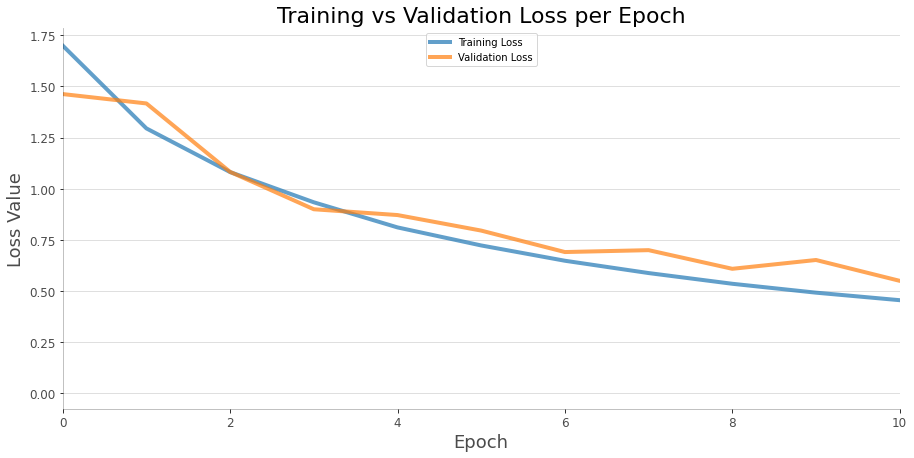

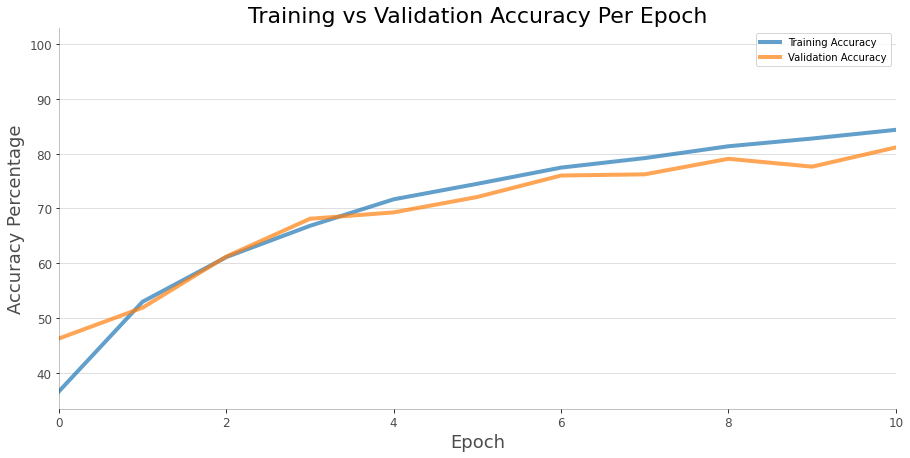

In [11]:

import pandas as pd
#Train Vs Validation loss
df = pd.DataFrame({'Training Loss':train_loss, 'Validation Loss':validation_loss})
df.plot(linewidth=4, alpha=0.7, figsize=(15,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training vs Validation Loss per Epoch', fontsize=22)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()
# Here plot epoch and accuracy over val/test set

df = pd.DataFrame({'Training Accuracy':train_acc, 'Validation Accuracy':validation_acc})
df.plot(linewidth=4, alpha=0.7, figsize=(15,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training vs Validation Accuracy Per Epoch', fontsize=22)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Accuracy Percentage', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper right')
plt.show()


In [16]:
def test_model(model, test_loader, BEST_MODEL):
   model.load_state_dict(torch.load(BEST_MODEL))

   with torch.no_grad():
     correct_predictions = []
     testing_acc_scores = []
     wrong_predictions = []
     all_targets = []
     all_preds = []

     for images, targets in iter(test_loader):
       images = images.to(device)
       targets = targets.to(device)
       outputs = model(images)
      
       _, preds = torch.max(outputs, 1)
       correct_indicies = (preds == targets).nonzero(as_tuple=True)[0]
       c_images = images[correct_indicies]
       c_targets = targets[correct_indicies]
       c_wrong_preds = preds[correct_indicies]
       testing_acc_scores.append(len(correct_indicies)/targets.shape[0])

       wrong_indicies = (preds != targets).nonzero(as_tuple=True)[0]
       w_images = images[wrong_indicies]
       w_targets = targets[wrong_indicies]
       w_wrong_preds = preds[wrong_indicies]
  
       correct_predictions += zip(c_images, c_targets, c_wrong_preds)
       wrong_predictions += zip(w_images, w_targets, w_wrong_preds)
       all_targets+= zip(targets.cpu().numpy())
       all_preds+= zip(preds.cpu().numpy())
       

     return (sum(testing_acc_scores)/len(testing_acc_scores))*100, correct_predictions, wrong_predictions, all_targets, all_preds
          


In [17]:
test_accuracy, correct_predictions, wrong_predictions, all_targets, all_preds = test_model(ResNet34, test_loader, BEST_MODEL='/content/gdrive/MyDrive/sgdresnet/Accuracy_89.82397151898735_batchsize_128_lr_0.001.ckpt' )


In [18]:
print(f'Accuracy of the network on the training dataset: {max(train_acc)}')
print(f'Accuracy of the network on the validation dataset: {max(validation_acc)}')
print(f'Accuracy of the network on the test dataset: {round(test_accuracy)}')
print(len(correct_predictions))
print(len(wrong_predictions))
print(len(all_preds))
print(len(all_targets))


Accuracy of the network on the training dataset: 99.75539137380191
Accuracy of the network on the validation dataset: 89.82397151898735
Accuracy of the network on the test dataset: 89
8924
1076
10000
10000
